AI-QSAR model for carcinogenicity: single task classification model

Author: Chi-Yun Chen; Advisor: Zhoumeng Lin; Date created: Nov.15.2024

Description: Input data preparing (CAS—CID—SMILES), data visualization (Violin plot, bar plots, PCA plots, and AD determination)

##Install necessary libraries

In [ ]:
!pip install --upgrade pip
!pip install -q PubChemPy

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#Install basic python pcakges
import pandas as pd
import numpy as np

import pubchempy as pcp
from pubchempy import get_compounds, Compound
import time

In [ ]:
# In a notebook cell
!cat /etc/redhat-release
!python3 --version
!python3 -c "import torch; print(torch.__version__)"
!nvcc --version       # if nvcc is on your PATH
!nvidia-smi           # shows CUDA version
!python3 - <<EOF
import cv2
print(cv2.__version__)

!module list

Red Hat Enterprise Linux release 8.10 (Ootpa)
Python 3.10.12
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/apps/jupyter/6.5.4/lib/python3.10/site-packages/torch/__init__.py", line 1598, in <module>
    import torch.utils.data
  File "/apps/jupyter/6.5.4/lib/python3.10/site-packages/torch/utils/data/__init__.py", line 21, in <module>
    from torch.utils.data.datapipes.datapipe import (
  File "/apps/jupyter/6.5.4/lib/python3.10/site-packages/torch/utils/data/datapipes/__init__.py", line 1, in <module>
    from . import iter
  File "/apps/jupyter/6.5.4/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/__init__.py", line 1, in <module>
    from torch.utils.data.datapipes.iter.utils import (
  File "/apps/jupyter/6.5.4/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/utils.py", line 3, in <module>
    from torch.utils.data.datapipes.datapipe import IterDataPipe
  File "/apps/jupyter/6.5.4/lib/python3.10/site-packages/torch/utils/

# Import the raw dataset

In [ ]:
df = pd.read_csv('Unique_CANCER.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 82 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   CAS                                                957 non-null    object
 1   Alimentary system                                  957 non-null    int64 
 2   Endocrine system                                   957 non-null    int64 
 3   Exocrine system                                    957 non-null    int64 
 4   Haematolymphoid system                             957 non-null    int64 
 5   Hepatobiliary system                               957 non-null    int64 
 6   Reproductive system                                957 non-null    int64 
 7   Respiratory system                                 957 non-null    int64 
 8   Skin and soft tissue                               957 non-null    int64 
 9   Special Senses System

In [ ]:
df.head()

CAS  Alimentary system  Endocrine system  Exocrine system  \
0    101-55-3                  0                 0                0   
1    101-68-8                  0                 0                0   
2  10102-45-1                  0                 0                0   
3   1024-57-3                  0                 0                0   
4    106-44-5                  0                 0                0   

   Haematolymphoid system  Hepatobiliary system  Reproductive system  \
0                       0                     0                    0   
1                       0                     0                    0   
2                       0                     0                    0   
3                       0                     1                    0   
4                       0                     0                    0   

   Respiratory system  Skin and soft tissue  Special Senses System  ...  \
0                   0                     0                      0  ...   
1                   0                     0                      0  ...   
2                   0                     0                      0  ...   
3                   0                     0                      0  ...   
4                   0                     1                      0  ...   

   tox21-shh-3t3-gli3-agonist-p1_shh-agonist_1  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   tox21-shh-3t3-gli3-antagonist-p1_shh-antagonist_1  \
0                                                  0   
1                                                  1   
2                                                  1   
3                                                  0   
4                                                  0   

   tox21-trhr-hek293-p1_trhr-agonist_1  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   

   tox21-trhr-hek293-p1_trhr-antagonist_1  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   tox21-tshr-agonist-p1_tshr-agonist_1  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   tox21-tshr-antagonist-p1_tshr-antagonist_1  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   tox21-vdr-bla-agonist-p1_vdr-agonist_1  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   tox21-vdr-bla-antagonist-p1_vdr-antagonist_1  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

                                       Chemical Name  Source  
0                              p-Bromodiphenyl ether    IRIS  
1  Methylene Diphenyl Diisocyanate (monomeric MDI...    IRIS  
2                                   Thallium nitrate    IRIS  
3                                 Heptachlor epoxide    IRIS  
4                                     4-Methylphenol    IRIS  

[5 rows x 84 columns]

In [ ]:
# X features: CAS numbers
X_cas = df.loc[:, ['CAS']]
X_cas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CAS     957 non-null    object
dtypes: object(1)
memory usage: 7.6+ KB


# Extract SMILES codes from PubChem database

Define a function for SMILES conversion

In [ ]:
'''
This script enables automatically connecting to the PubChem database,
Transfer of CAS numbers which are converted to CID (PubChem's compound identifier)
as first step and then resolved to respective SMILES codes.
'''

def cas_to_cid (df):
  # Add new column 'PubChemCID' to the dataframe and initialize with 'None'
  df['PubChemCID'] = None
  # Searching PubChem for CID
  for i, CAS in df['CAS'].items():
    try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")

    except Exception as e:
        pass # silent the error message; otherwise it will print a lot error message: server is busy

  # Check PubChemCID; If CID is None, run the "While loop" and request PubChem server again to get all CID
  while df['PubChemCID'].isnull().sum() > 0:
    print (df['PubChemCID'].isnull().sum())
    for i, CAS in df[df['PubChemCID'].isnull()]['CAS'].items():
      try:
        # Searching PubChem for CID using CAS number
        results = get_compounds(CAS, 'name')
        if results:
            cid = results[0].cid
            df.at[i, 'PubChemCID'] = cid
        else:
            print(f"No results found for CAS number {CAS}")
      except Exception as e:
        pass

    return df

Run the function

In [ ]:
# Convert CAS to CID
X_cas_cid = cas_to_cid (X_cas)

No results found for CAS number 10102-45-1
No results found for CAS number 10326-27-9
No results found for CAS number 13010-08-7
No results found for CAS number 165252-70-0
No results found for CAS number 25013-15-4
No results found for CAS number 25265-71-8
No results found for CAS number 1330-20-7
No results found for CAS number 32534-81-9
No results found for CAS number 26471-62-5
27
No results found for CAS number 10102-45-1
No results found for CAS number 10326-27-9
No results found for CAS number 13010-08-7
No results found for CAS number 165252-70-0
No results found for CAS number 25013-15-4
No results found for CAS number 25265-71-8
No results found for CAS number 1330-20-7
No results found for CAS number 32534-81-9
No results found for CAS number 26471-62-5


In [ ]:
# Function to manually input missing CIDs
def manual_input_cids(df):
    missing_cids = df[df['PubChemCID'].isnull()]
    for i, row in missing_cids.iterrows():
        cas = row['CAS']
        cid = input(f"Enter PubChem CID for CAS {cas}: ")
        df.at[i, 'PubChemCID'] = cid
    return df

Use the link to search the missing CID: https://pubchem.ncbi.nlm.nih.gov/
✅ Enter PubChem CID for CAS 10102-45-1: 24937
✅ Enter PubChem CID for CAS 32536-52-0: 6537506
✅ Enter PubChem CID for CAS 10326-27-9: 5284346
✅ Enter PubChem CID for CAS 1300-72-7: 23668192
✅ Enter PubChem CID for CAS 13010-08-7: 135464373
✅ Enter PubChem CID for CAS 165252-70-0: 135418283
✅ Enter PubChem CID for CAS 18883-66-4: 29327
✅ Enter PubChem CID for CAS 25013-15-4: 7529
✅ Enter PubChem CID for CAS 25265-71-8: 6537503
✅ Enter PubChem CID for CAS 68515-48-0: 590836
✅ Enter PubChem CID for CAS 1330-20-7: 7929
✅ Enter PubChem CID for CAS 32534-81-9: 36159
✅ Enter PubChem CID for CAS 1897-45-6: 15910
✅ Enter PubChem CID for CAS 26471-62-5: 11443

In [ ]:
X_cas_cid = manual_input_cids(X_cas_cid)

Enter PubChem CID for CAS 10102-45-1:  24937
Enter PubChem CID for CAS 10326-27-9:  5284346
Enter PubChem CID for CAS 13010-08-7:  135464373
Enter PubChem CID for CAS 165252-70-0:  135418283
Enter PubChem CID for CAS 25013-15-4:  7529
Enter PubChem CID for CAS 25265-71-8:  6537503
Enter PubChem CID for CAS 1330-20-7:  7929
Enter PubChem CID for CAS 32534-81-9:  36159
Enter PubChem CID for CAS 26471-62-5:  11443


In [ ]:
# Check if column 'PubChemCID' has 957 non-null
X_cas_cid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CAS         957 non-null    object
 1   PubChemCID  957 non-null    object
dtypes: object(2)
memory usage: 15.1+ KB


In [ ]:
# Function for converting CID to SMILES with retry and backoff
def cid_to_smiles(data, max_retries=5, initial_wait_time=10):
    data['SMILES'] = None

    for i, cid in data['PubChemCID'].items():
        retries = 0
        wait_time = initial_wait_time

        while retries < max_retries:
            try:
                compound = pcp.Compound.from_cid(cid)
                if compound:
                    smiles = compound.canonical_smiles
                    data.at[i, 'SMILES'] = smiles
                    break  # Exit retry loop when successful
                else:
                    print(f"No results found for PubChemCID {cid}")
                    break
            except Exception as e:
                if 'PUGREST.ServerBusy' in str(e):
                    print(f"Server busy for PubChemCID {cid}, retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                    retries += 1
                    wait_time *= 2  # Exponential backoff
                else:
                    print(f"Error for PubChemCID {cid}: {e}")
                    break

    if data['SMILES'].isnull().sum() > 0:
        print(f"Warning: {data['SMILES'].isnull().sum()} SMILES could not be retrieved after maximum retries.")

    return data

In [ ]:
# Convert CID to SMILES
X_cas_smiles = cid_to_smiles(X_cas_cid)

Server busy for PubChemCID 643833, retrying in 10 seconds...
Server busy for PubChemCID 10707, retrying in 10 seconds...
Server busy for PubChemCID 5280961, retrying in 10 seconds...
Server busy for PubChemCID 108005, retrying in 10 seconds...
Server busy for PubChemCID 7044, retrying in 10 seconds...
Server busy for PubChemCID 5455, retrying in 10 seconds...
Server busy for PubChemCID 11664966, retrying in 10 seconds...
Server busy for PubChemCID 7529, retrying in 10 seconds...
Server busy for PubChemCID 1982, retrying in 10 seconds...
Server busy for PubChemCID 3385, retrying in 10 seconds...
Server busy for PubChemCID 5905, retrying in 10 seconds...
Server busy for PubChemCID 11057, retrying in 10 seconds...
Server busy for PubChemCID 12901, retrying in 10 seconds...
Server busy for PubChemCID 24268, retrying in 10 seconds...
Server busy for PubChemCID 91731, retrying in 10 seconds...
Server busy for PubChemCID 7017, retrying in 10 seconds...
Server busy for PubChemCID 7839, retryin

In [ ]:
# Merge the dataframes on 'CAS', adding 'SMILES' from X_cas_smiles to df_merged
df_merged = df.merge(X_cas_smiles[['CAS', 'PubChemCID', 'SMILES']], on='CAS', how='left')

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 84 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   CAS                                                957 non-null    object
 1   Alimentary system                                  957 non-null    int64 
 2   Endocrine system                                   957 non-null    int64 
 3   Exocrine system                                    957 non-null    int64 
 4   Haematolymphoid system                             957 non-null    int64 
 5   Hepatobiliary system                               957 non-null    int64 
 6   Reproductive system                                957 non-null    int64 
 7   Respiratory system                                 957 non-null    int64 
 8   Skin and soft tissue                               957 non-null    int64 
 9   Special Senses System

In [ ]:
# Export the SMILES-labeled dataset
df_merged.to_csv("SMILES_cancer df.csv", index=False)

# Check and remove the Y of duplicate SMILES
Since these duplicates contain different y and in vitro data, we need to remove all the duplicated chemicals (n = 12) from the original dataframe

In [ ]:
df = pd.read_csv('SMILES_cancer df.csv')

In [ ]:
duplicates = df[df.duplicated(subset='SMILES', keep=False)]

# Show the removed chemicals (duplicates)
print(duplicates)

            CAS  Alimentary system  Endocrine system  Exocrine system  \
23     156-59-2                  0                 0                0   
24     156-60-5                  0                 0                0   
47   60348-60-9                  0                 0                0   
652  12789-03-6                  0                 1                0   
661    319-84-6                  0                 0                0   
662    319-85-7                  0                 0                0   
663  32534-81-9                  0                 1                0   
675     60-57-1                  0                 0                0   
676    608-73-1                  0                 0                0   
687     72-20-8                  0                 0                0   
867     57-74-9                  0                 0                0   
869     58-89-9                  0                 0                0   

     Haematolymphoid system  Hepatobiliary system 

In [ ]:
# Filter out rows from df where the SMILES column matches any SMILES in duplicates
df_finalized = df[~df['CAS'].isin(duplicates['CAS'])]
df_finalized = df_finalized.reset_index(drop=True)
df_finalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 84 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   CAS                                                945 non-null    object
 1   Alimentary system                                  945 non-null    int64 
 2   Endocrine system                                   945 non-null    int64 
 3   Exocrine system                                    945 non-null    int64 
 4   Haematolymphoid system                             945 non-null    int64 
 5   Hepatobiliary system                               945 non-null    int64 
 6   Reproductive system                                945 non-null    int64 
 7   Respiratory system                                 945 non-null    int64 
 8   Skin and soft tissue                               945 non-null    int64 
 9   Special Senses System

In [ ]:
print(df_finalized)

            CAS  Alimentary system  Endocrine system  Exocrine system  \
0      101-55-3                  0                 0                0   
1      101-68-8                  0                 0                0   
2    10102-45-1                  0                 0                0   
3     1024-57-3                  0                 0                0   
4      106-44-5                  0                 0                0   
..          ...                ...               ...              ...   
940     99-56-9                  0                 0                0   
941     99-57-0                  0                 0                0   
942     99-59-2                  0                 0                0   
943     99-99-0                  0                 0                0   
944    999-81-5                  0                 0                0   

     Haematolymphoid system  Hepatobiliary system  Reproductive system  \
0                         0                     0

# Fingerprints preparing

In [ ]:
# Molecular Descriptors Calculation
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, DataStructs
from rdkit.DataStructs import ExplicitBitVect
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.preprocessing import MinMaxScaler        # Feature scaling for RDKit descriptors

In [ ]:
# Define a function that transforms SMILES string into 2D RDKIT descriptors
def cal_rdkit_descr(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    mol_descriptors = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)

    return pd.DataFrame(mol_descriptors, index=smiles, columns=["rdkit_" + str(i) for i in desc_names])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE) or--
# --the Extended-Connectivity Fingerprints (ECFP) descriptors (if use_features = FALSE)

def cal_ECFP6_descr(smiles,
            R = 3,               # no default value, usually set 2 for similarity search and 3 for machine learning
            nBits = 2**10, # nBits = 1024; default is 2048
            use_features = False,
            use_chirality = False):

   '''
   Inputs:
   - smiles...SMILES string of input compounds
   - R....Maximum radius of circular substructures--By using this radius parameter, we compute ECFP6 (the equivalent of radius 3)
   - nBits....number of bits, default is 2048. 1024 is also widely used.
   - use_features...if true then use pharmacophoric atom features (FCFPs), if false then use standard DAYLIGHT atom features (ECFP)
   - use_chirality...if true then append tetrahedral chirality flags to atom features
   Outputs:
   - pd.DataFrame...ECFP or FCFPs with length nBits and maximum radus R

   '''
   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   ecfp_descriptors = []
   for mol in mols:
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(ecfp, array)
        ecfp_descriptors.append(ecfp)

   return pd.DataFrame([list(l) for l in ecfp_descriptors], index = smiles, columns=[f'ECFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE)
def cal_FCFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = True,
            use_chirality = False):

   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   fcfp_descriptors = []
   for mol in mols:
        fcfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fcfp, array)
        fcfp_descriptors.append(fcfp)

   return pd.DataFrame([list(l) for l in fcfp_descriptors], index = smiles, columns=[f'FCFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into an MACCS fingerprints

def cal_MACCS_descr(smiles):

   mols = [Chem.MolFromSmiles(i) for i in smiles]
   MACCS_descriptors = []
   for mol in mols:
        fp = MACCSkeys.GenMACCSKeys (mol)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        MACCS_descriptors.append(fp)

   return pd.DataFrame([list(l) for l in MACCS_descriptors], index = smiles, columns=[f'MACCS_Bit_{i}' for i in range(167)])

RDKit descriptors

In [ ]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df_finalized['SMILES'])
# Check if there are any missing values
missing_summary = rdkit_descrs.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

print("Columns with missing values and their counts:")
print(missing_summary)

Columns with missing values and their counts:
rdkit_MaxPartialCharge       14
rdkit_MinPartialCharge       14
rdkit_MaxAbsPartialCharge    14
rdkit_MinAbsPartialCharge    14
rdkit_BCUT2D_MWHI            59
rdkit_BCUT2D_MWLOW           59
rdkit_BCUT2D_CHGHI           59
rdkit_BCUT2D_CHGLO           59
rdkit_BCUT2D_LOGPHI          59
rdkit_BCUT2D_LOGPLOW         59
rdkit_BCUT2D_MRHI            59
rdkit_BCUT2D_MRLOW           59
dtype: int64


In [ ]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df_finalized['SMILES']).drop(['rdkit_MaxPartialCharge','rdkit_MinPartialCharge','rdkit_MaxAbsPartialCharge', 'rdkit_MinAbsPartialCharge', 'rdkit_BCUT2D_MWHI', 'rdkit_BCUT2D_MWLOW', 'rdkit_BCUT2D_CHGHI', 'rdkit_BCUT2D_CHGLO', 'rdkit_BCUT2D_LOGPHI', 'rdkit_BCUT2D_LOGPLOW', 'rdkit_BCUT2D_MRHI', 'rdkit_BCUT2D_MRLOW'], axis=1)
rdkit_descrs

rdkit_MaxEStateIndex  \
SMILES                                                                   
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                                 7.814480   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                        10.471720   
[N+](=O)([O-])[O-].[Tl+]                                      8.250000   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl              8.818441   
CC1=CC=C(C=C1)O                                               7.418449   
...                                                                ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                                10.684692   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                                10.622830   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                               10.755498   
CC1=CC=C(C=C1)[N+](=O)[O-]                                   10.566282   
C[N+](C)(C)CCCl.[Cl-]                                         7.501736   

                                                  rdkit_MinEStateIndex  \
SMILES                                                                   
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                                -0.628907   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                        -3.021449   
[N+](=O)([O-])[O-].[Tl+]                                     -1.750000   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl             -2.713642   
CC1=CC=C(C=C1)O                                              -2.735790   
...                                                                ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                                -1.071708   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                                -1.052150   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                               -3.059947   
CC1=CC=C(C=C1)[N+](=O)[O-]                                   -2.852286   
C[N+](C)(C)CCCl.[Cl-]                                        -3.948110   

                                                  rdkit_MaxAbsEStateIndex  \
SMILES                                                                      
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                                    7.814480   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                           10.471720   
[N+](=O)([O-])[O-].[Tl+]                                         8.250000   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl                 8.818441   
CC1=CC=C(C=C1)O                                                  7.418449   
...                                                                   ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                                   10.684692   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                                   10.622830   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                                  10.755498   
CC1=CC=C(C=C1)[N+](=O)[O-]                                      10.566282   
C[N+](C)(C)CCCl.[Cl-]                                            7.501736   

                                                  rdkit_MinAbsEStateIndex  \
SMILES                                                                      
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                                    0.054712   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                            0.662247   
[N+](=O)([O-])[O-].[Tl+]                                         0.000000   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl                 0.418935   
CC1=CC=C(C=C1)O                                                  0.580556   
...                                                                   ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                                    0.159174   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                                    0.169954   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                                   0.269954   
CC1=CC=C(C=C1)[N+](=O)[O-]                                       0.807315   
C[N+](C)(C)CCCl.[Cl-]                                            0.000000   

                                                  rdkit_qed  rdkit_MolWt  \
SMILES                                      

In [ ]:
has_missing = rdkit_descrs.isnull().any().any()
print(f"Does the DataFrame have missing values? {has_missing}")

Does the DataFrame have missing values? False


In [ ]:
identical_columns = [col for col in rdkit_descrs.columns if rdkit_descrs[col].nunique() == 1]
print("Columns with identical values:", identical_columns)

Columns with identical values: ['rdkit_SMR_VSA8', 'rdkit_SlogP_VSA9', 'rdkit_fr_diazo', 'rdkit_fr_nitro_arom_nonortho', 'rdkit_fr_prisulfonamd', 'rdkit_fr_unbrch_alkane']


In [ ]:
all_zero_columns = [col for col in identical_columns if rdkit_descrs[col].iloc[0] == 0]
print("Columns with identical values that are all 0:", all_zero_columns)

Columns with identical values that are all 0: ['rdkit_SMR_VSA8', 'rdkit_SlogP_VSA9', 'rdkit_fr_diazo', 'rdkit_fr_nitro_arom_nonortho', 'rdkit_fr_prisulfonamd', 'rdkit_fr_unbrch_alkane']


In [ ]:
rdkit = rdkit_descrs.drop(columns=all_zero_columns)

#Fingerprints

In [ ]:
# Calculating ECFP6 fingerprints
ECFP6_descrs = cal_ECFP6_descr(df_finalized['SMILES'])
ECFP6_descrs

ECFP6_Bit_0  ECFP6_Bit_1  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0            0   

                                                  ECFP6_Bit_2  ECFP6_Bit_3  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0            0   

                                                  ECFP6_Bit_4  ECFP6_Bit_5  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0            0   

                                                  ECFP6_Bit_6  ECFP6_Bit_7  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0        

In [ ]:
has_missing = ECFP6_descrs.isnull().any().any()
print(f"Does the DataFrame have missing values? {has_missing}")

Does the DataFrame have missing values? False


In [ ]:
# Calculating FCFP6 fingerprints
FCFP6_descrs = cal_FCFP6_descr(df_finalized['SMILES'])
FCFP6_descrs

FCFP6_Bit_0  FCFP6_Bit_1  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       1            0   
[N+](=O)([O-])[O-].[Tl+]                                    1            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            1            0   
CC1=CC=C(C=C1)O                                             1            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              1            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  1            0   
C[N+](C)(C)CCCl.[Cl-]                                       1            0   

                                                  FCFP6_Bit_2  FCFP6_Bit_3  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               1            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       1            0   
[N+](=O)([O-])[O-].[Tl+]                                    1            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            1            0   
CC1=CC=C(C=C1)O                                             0            1   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               1            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               1            1   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              1            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  1            0   
C[N+](C)(C)CCCl.[Cl-]                                       0            0   

                                                  FCFP6_Bit_4  FCFP6_Bit_5  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               1            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       1            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             1            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               1            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               1            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              1            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  1            0   
C[N+](C)(C)CCCl.[Cl-]                                       0            0   

                                                  FCFP6_Bit_6  FCFP6_Bit_7  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0        

In [ ]:
has_missing = FCFP6_descrs.isnull().any().any()
print(f"Does the DataFrame have missing values? {has_missing}")

Does the DataFrame have missing values? False


In [ ]:
# Calculating MACCS fingerprints
MACCS_descrs = cal_MACCS_descr(df_finalized['SMILES'])
MACCS_descrs

MACCS_Bit_0  MACCS_Bit_1  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0            0   

                                                  MACCS_Bit_2  MACCS_Bit_3  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0            0   

                                                  MACCS_Bit_4  MACCS_Bit_5  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0            0   

                                                  MACCS_Bit_6  MACCS_Bit_7  \
SMILES                                                                       
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br                               0            0   
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O                       0            0   
[N+](=O)([O-])[O-].[Tl+]                                    0            0   
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl            0            0   
CC1=CC=C(C=C1)O                                             0            0   
...                                                       ...          ...   
C1=CC(=C(C=C1[N+](=O)[O-])N)N                               0            0   
C1=CC(=C(C=C1[N+](=O)[O-])N)O                               0            0   
COC1=C(C=C(C=C1)[N+](=O)[O-])N                              0            0   
CC1=CC=C(C=C1)[N+](=O)[O-]                                  0            0   
C[N+](C)(C)CCCl.[Cl-]                                       0        

In [ ]:
has_missing = MACCS_descrs.isnull().any().any()
print(f"Does the DataFrame have missing values? {has_missing}")

Does the DataFrame have missing values? False


In [ ]:
identical_Mcolumns = [col for col in MACCS_descrs.columns if MACCS_descrs[col].nunique() == 1]
print("Columns with identical values:", identical_Mcolumns)

Columns with identical values: ['MACCS_Bit_0', 'MACCS_Bit_1', 'MACCS_Bit_2', 'MACCS_Bit_4', 'MACCS_Bit_6', 'MACCS_Bit_20']


In [ ]:
all_zero_Mcolumns = [col for col in identical_Mcolumns if MACCS_descrs[col].iloc[0] == 0]
print("Columns with identical values that are all 0:", all_zero_Mcolumns)

Columns with identical values that are all 0: ['MACCS_Bit_0', 'MACCS_Bit_1', 'MACCS_Bit_2', 'MACCS_Bit_4', 'MACCS_Bit_6', 'MACCS_Bit_20']


In [ ]:
MACCS = MACCS_descrs.drop(columns=all_zero_Mcolumns)

In [ ]:
# Applying feature scaling for RDKit descriptors
# MinMaxScaler: scaled to a fixed range (e.g., [0, 1])
scaler = MinMaxScaler()
X_rdkit_descrs = rdkit
X_rdkit_descrs_scal = scaler.fit_transform(X_rdkit_descrs)
X_rdkit_descrs_scal = pd.DataFrame(X_rdkit_descrs_scal, columns = rdkit.columns.values.tolist())
X_rdkit_descrs_scal

rdkit_MaxEStateIndex  rdkit_MinEStateIndex  rdkit_MaxAbsEStateIndex  \
0                0.252207              0.871866                 0.252207   
1                0.413434              0.688662                 0.413434   
2                0.278632              0.786021                 0.278632   
3                0.313122              0.712232                 0.313122   
4                0.228178              0.710536                 0.228178   
..                    ...                   ...                      ...   
940              0.426356              0.837960                 0.426356   
941              0.422603              0.839457                 0.422603   
942              0.430652              0.685714                 0.430652   
943              0.419172              0.701616                 0.419172   
944              0.233231              0.617705                 0.233231   

     rdkit_MinAbsEStateIndex  rdkit_qed  rdkit_MolWt  rdkit_HeavyAtomMolWt  \
0                   0.010834   0.816642     0.125322              0.125410   
1                   0.131135   0.648200     0.126015              0.125498   
2                   0.000000   0.339999     0.135731              0.141770   
3                   0.082955   0.456269     0.209780              0.214961   
4                   0.114959   0.559707     0.040410              0.038520   
..                       ...        ...          ...                   ...   
940                 0.031519   0.361730     0.067517              0.067084   
941                 0.033653   0.273193     0.068109              0.068321   
942                 0.053455   0.421305     0.076559              0.075777   
943                 0.159860   0.453409     0.057877              0.057149   
944                 0.000000   0.325415     0.070487              0.066390   

     rdkit_ExactMolWt  rdkit_NumValenceElectrons  rdkit_NumRadicalElectrons  \
0            0.124737                   0.099359                        0.0   
1            0.125997                   0.134615                        0.0   
2            0.136176                   0.028846                        1.0   
3            0.207811                   0.147436                        0.0   
4            0.040401                   0.054487                        0.0   
..                ...                        ...                        ...   
940          0.067521                   0.080128                        0.0   
941          0.068114                   0.080128                        0.0   
942          0.076562                   0.089744                        0.0   
943          0.057874                   0.070513                        0.0   
944          0.069925                   0.070513                        0.0   

     ...  rdkit_fr_quatN  rdkit_fr_sulfide  rdkit_fr_sulfonamd  \
0    ...             0.0               0.0                 0.0   
1    ...             0.0               0.0                 0.0   
2    ...             0.0               0.0                 0.0   
3    ...             0.0               0.0                 0.0   
4    ...             0.0               0.0                 0.0   
..   ...             ...               ...                 ...   
940  ...             0.0               0.0                 0.0   
941  ...             0.0               0.0                 0.0   
942  ...             0.0               0.0                 0.0   
943  ...             0.0               0.0                 0.0   
944  ...             1.0               0.0                 0.0   

     rdkit_fr_sulfone  rdkit_fr_term_acetylene  rdkit_fr_tetrazole  \
0                 0.0                      0.0                 0.0   
1                 0.0                      0.0                 0.0   
2                 0.0                      0.0                 0.0   
3                 0.0                      0.0                 0.0   
4                 0.0                      0.0                 

In [ ]:
# Single task
Ya_2d = df_finalized.loc[:, ['Alimentary system']]
Yen_2d = df_finalized.loc[:, ['Endocrine system']]
Yex_2d = df_finalized.loc[:, ['Exocrine system']]
Yha_2d = df_finalized.loc[:, ['Haematolymphoid system']]
Yhe_2d = df_finalized.loc[:, ['Hepatobiliary system']]
Yrep_2d = df_finalized.loc[:, ['Reproductive system']]
Yres_2d = df_finalized.loc[:, ['Respiratory system']]
Ysk_2d = df_finalized.loc[:, ['Skin and soft tissue']]
Ysp_2d = df_finalized.loc[:, ['Special Senses System']]
Yu_2d = df_finalized.loc[:, ['Urinary system']]

In [ ]:
# Convert Y as a column vector to a 1D array
Ya = Ya_2d.values.ravel()
Yen = Yen_2d.values.ravel()
Yex = Yex_2d.values.ravel()
Yha = Yha_2d.values.ravel()
Yhe = Yhe_2d.values.ravel()
Yrep = Yrep_2d.values.ravel()
Yres = Yres_2d.values.ravel()
Ysk = Ysk_2d.values.ravel()
Ysp = Ysp_2d.values.ravel()
Yu = Yu_2d.values.ravel()
print(Ya.shape)
print(Yen.shape)
print(Yex.shape)
print(Yha.shape)
print(Yhe.shape)
print(Yrep.shape)
print(Yres.shape)
print(Ysk.shape)
print(Ysp.shape)
print(Yu.shape)

(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)


In [ ]:
# Combine all 10 columns into a single column using the "any" condition
df_finalized['whole'] = (df_finalized.iloc[:, 1:10].sum(axis=1) > 0).astype(int)

In [ ]:
Y_2d = df_finalized.loc[:, ['whole']]

In [ ]:
# Convert Y as a column vector to a 1D array
Ya = Ya_2d.values.ravel()
Yen = Yen_2d.values.ravel()
Yex = Yex_2d.values.ravel()
Yha = Yha_2d.values.ravel()
Yhe = Yhe_2d.values.ravel()
Yrep = Yrep_2d.values.ravel()
Yres = Yres_2d.values.ravel()
Ysk = Ysk_2d.values.ravel()
Ysp = Ysp_2d.values.ravel()
Yu = Yu_2d.values.ravel()
Y = Y_2d.values.ravel()
print(Ya.shape)
print(Yen.shape)
print(Yex.shape)
print(Yha.shape)
print(Yhe.shape)
print(Yrep.shape)
print(Yres.shape)
print(Ysk.shape)
print(Ysp.shape)
print(Yu.shape)
print(Y.shape)

(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)
(945,)


In [ ]:
# X features: in vitro assays
X_vitro = df_finalized.iloc[:, 11:82]
X_vitro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 71 columns):
 #   Column                                             Non-Null Count  Dtype
---  ------                                             --------------  -----
 0   tox21-ache-p3_ache-inhibitor_1                     945 non-null    int64
 1   tox21-ache-p5_ache-inhibitor_1                     945 non-null    int64
 2   tox21-ahr-p1_ahr-agonist_1                         945 non-null    int64
 3   tox21-ap1-agonist-p1_ap1-agonist_1                 945 non-null    int64
 4   tox21-ar-bla-agonist-p1_ar-agonist_1               945 non-null    int64
 5   tox21-ar-bla-antagonist-p1_ar-antagonist_1         945 non-null    int64
 6   tox21-are-bla-p1_nrf2-agonist_1                    945 non-null    int64
 7   tox21-aromatase-p1_aromatase-inhibitor_1           945 non-null    int64
 8   tox21-car-agonist-p1_car-agonist_1                 945 non-null    int64
 9   tox21-car-antagonist-p1_car-anta

In [ ]:
# Concatenating dataframes horizontally (along columns): in vitro assays and descriptors
# X_rdkit: X_vitro and X_rdkit_descrs_scal
X_rdkit = pd.concat([X_vitro, X_rdkit_descrs_scal.reset_index(drop=True)], axis=1)
# X_ECFP6: X_vitro and ECFP6_descrs
X_ECFP6 = pd.concat([X_vitro, ECFP6_descrs.reset_index(drop=True)], axis=1)
# X_FCFP6: X_vitro and FCFP6_descrs
X_FCFP6 = pd.concat([X_vitro, FCFP6_descrs.reset_index(drop=True)], axis=1)
# X_MACCS: X_vitro and MACCS_descrs
X_MACCS = pd.concat([X_vitro, MACCS_descrs.reset_index(drop=True)], axis=1)
# X_All: X_vitro and four descriptors
X_All = pd.concat([X_vitro, X_rdkit_descrs_scal.reset_index(drop=True), ECFP6_descrs.reset_index(drop=True), FCFP6_descrs.reset_index(drop=True), MACCS_descrs.reset_index(drop=True)], axis = 1)

In [ ]:
print(X_rdkit.shape)
print(X_ECFP6.shape)
print(X_FCFP6.shape)
print(X_MACCS.shape)
print(X_All.shape)

(945, 262)
(945, 1095)
(945, 1095)
(945, 238)
(945, 2477)


# Feature distribution

In [ ]:
import seaborn as sns
import os
# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
output_dir = 'CancerData_plots'
os.makedirs(output_dir, exist_ok=True)

/scratch/local/1265170/ipykernel_3820163/3563149632.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


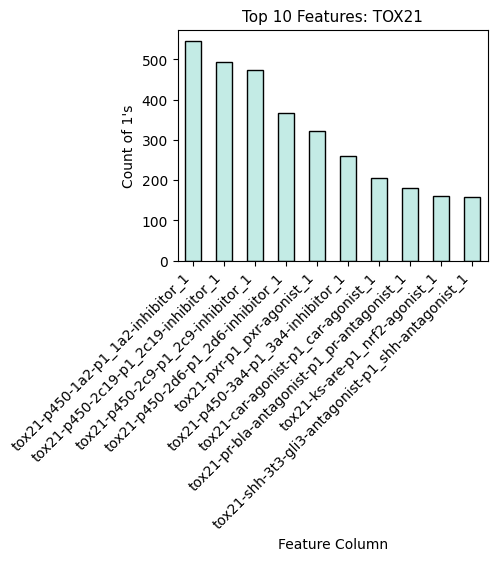

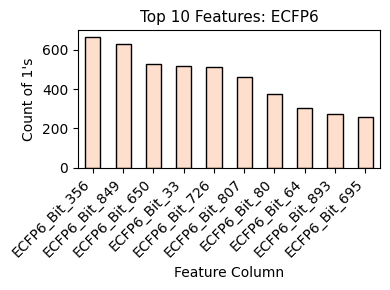

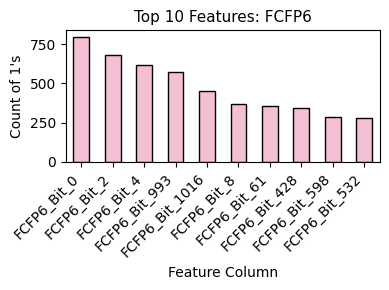

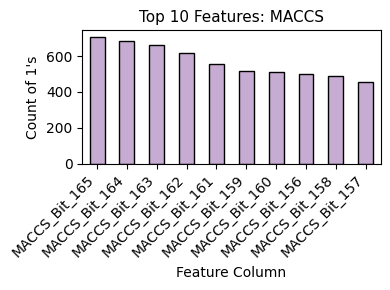

In [ ]:
# Define a list of colors: one for each plot.
plot_colors = ['#C3EBE5', '#FEDECD', '#F3BFD4', '#C6ACD2']

for color, (feature_name, X) in zip(plot_colors,
                                      zip(["TOX21", "ECFP6", "FCFP6", "MACCS"],
                                          [X_vitro, ECFP6_descrs, FCFP6_descrs, MACCS_descrs])):
    # Compute the count of 1's for each column.
    count_ones = X.sum(axis=0)

    # Select the top ten columns with the most 1's.
    top_ten = count_ones.nlargest(10)

    # Create a new figure for the plot.
    plt.figure(figsize=(4, 3))

    # Plot the results using the corresponding color.
    top_ten.plot(kind='bar', color=color, edgecolor='black')

    plt.title(f"Top 10 Features: {feature_name}", fontsize=11)
    plt.xlabel("Feature Column", fontsize=10)
    plt.ylabel("Count of 1's", fontsize=10)

    # Rotate x-axis labels for readability.
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'Bar_Plot_{feature_name}.png'), dpi=600)
    plt.show()

# RDKit descriptors distribution

In [ ]:
# Calculate the mean for each descriptor (column)
col_means = X_rdkit_descrs_scal.mean()

# Separate the columns based on their means
cols_high = col_means[col_means > 0.1].index
cols_medium = col_means[(col_means > 0.02) & (col_means <= 0.1)].index
cols_low = col_means[col_means <= 0.02].index

# Print out the number of descriptors in each group
print(f"Descriptors with mean > 0.1: {len(cols_high)}")
print(f"Descriptors with 0.02<mean<=0.1: {len(cols_medium)}")
print(f"Descriptors with mean <= 0.02: {len(cols_low)}")

Descriptors with mean > 0.1: 54
Descriptors with 0.02<mean<=0.1: 70
Descriptors with mean <= 0.02: 67


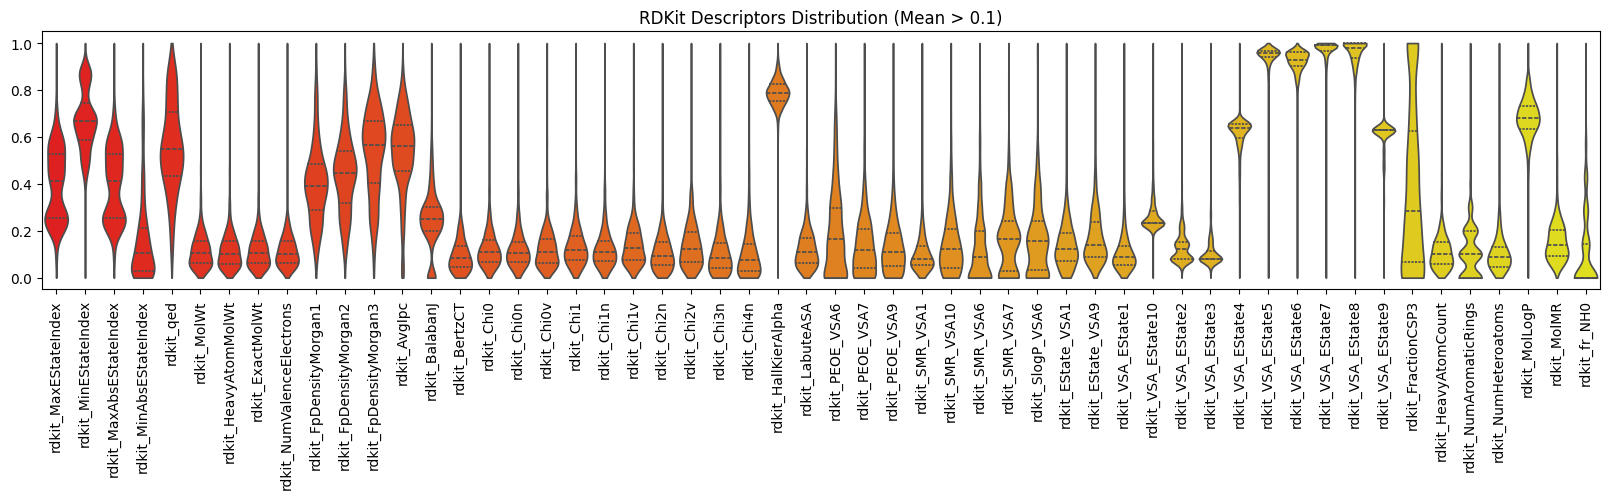

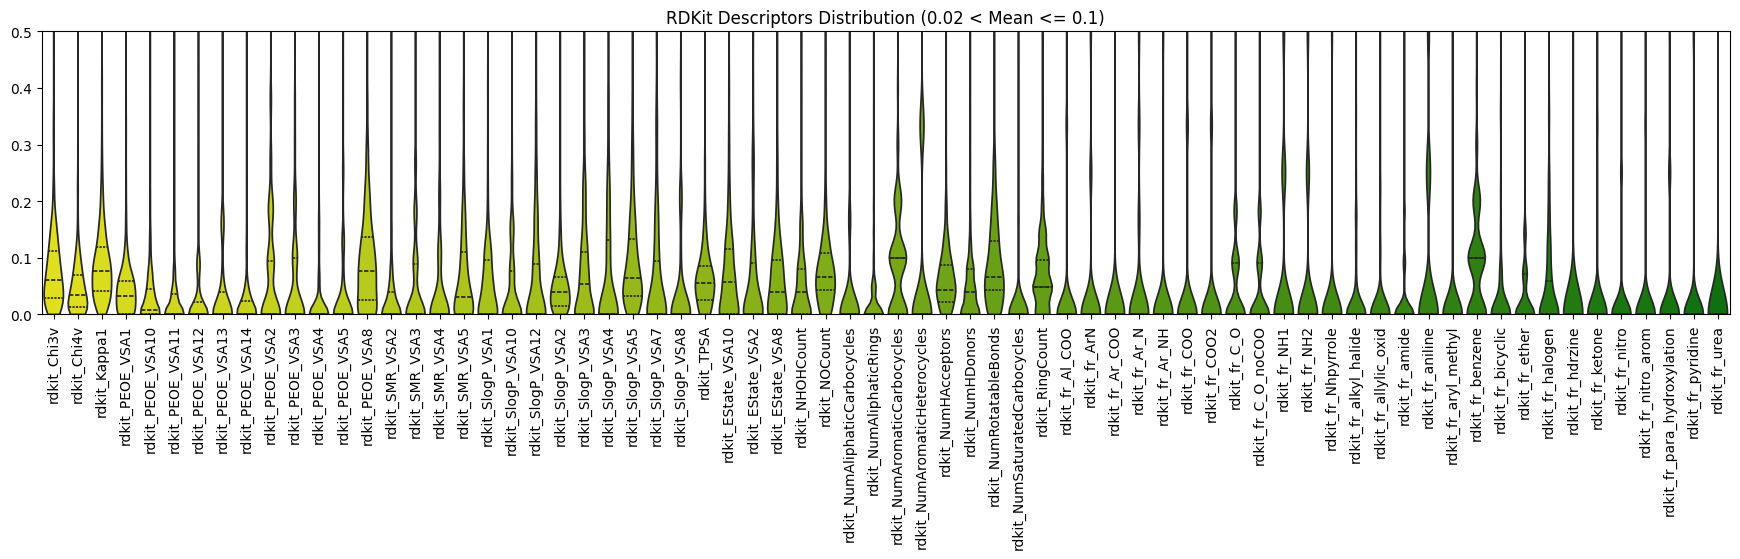

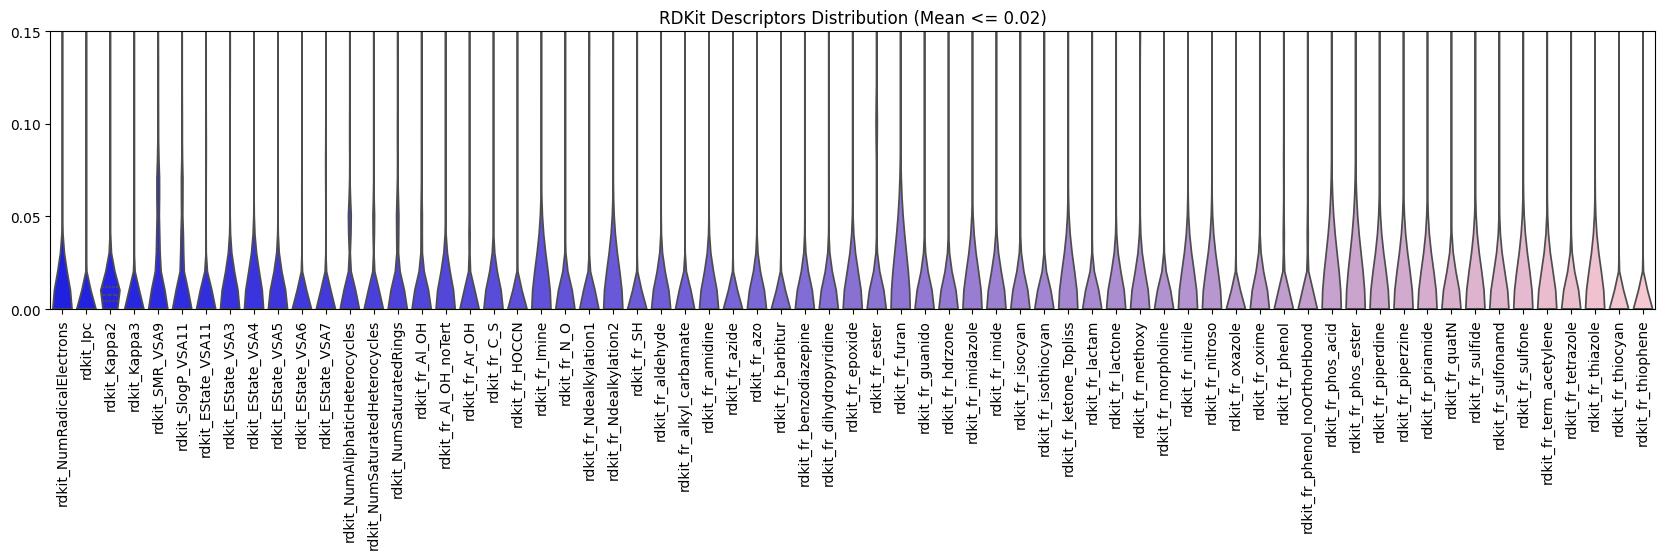

In [ ]:
# --- Create custom gradient palettes for each group ---
# For figure 1: red to yellow
n_high = len(cols_high)
if n_high > 1:
    cmap_high = LinearSegmentedColormap.from_list("red_yellow", ["red", "yellow"])
    palette_high = [cmap_high(i / (n_high - 1)) for i in range(n_high)]
else:
    palette_high = ["red"]

# For figure 2: yellow to green
n_medium = len(cols_medium)
if n_medium > 1:
    cmap_medium = LinearSegmentedColormap.from_list("yellow_green", ["yellow", "green"])
    palette_medium = [cmap_medium(i / (n_medium - 1)) for i in range(n_medium)]
else:
    palette_medium = ["yellow"]

# For figure 3: blue to pink
n_low = len(cols_low)
if n_low > 1:
    cmap_low = LinearSegmentedColormap.from_list("blue_pink", ["blue", "pink"])
    palette_low = [cmap_low(i / (n_low - 1)) for i in range(n_low)]
else:
    palette_low = ["lightgreen"]

# --- Figure 1: Violin plots for descriptors with mean > 0.1 ---
plt.figure(figsize=(len(cols_high) * 0.3, 5.1))
sns.violinplot(data=X_rdkit_descrs_scal[cols_high],
               orient='v',
               inner="quartile",
               cut=0,
               palette=palette_high)
plt.xticks(rotation=90)
plt.title("RDKit Descriptors Distribution (Mean > 0.1)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Violin_Plot_RDKit_Descriptors_I.png'), dpi=600)
plt.show()


# --- Figure 2: Violin plots for descriptors with 0.02 < mean <= 0.1 ---
plt.figure(figsize=(len(cols_medium) * 0.25, 5.7))
sns.violinplot(data=X_rdkit_descrs_scal[cols_medium],
               orient='v',
               inner="quartile",
               cut=0,
               palette=palette_medium)
plt.xticks(rotation=90)
plt.title("RDKit Descriptors Distribution (0.02 < Mean <= 0.1)")
plt.ylim(0, 0.5)
plt.yticks(np.arange(0, 0.51, 0.1))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Violin_Plot_RDKit_Descriptors_II.png'), dpi=600)
plt.show()


# --- Figure 3: Violin plots for descriptors with mean <= 0.02 ---
plt.figure(figsize=(len(cols_low) * 0.25, 5.7))
sns.violinplot(data=X_rdkit_descrs_scal[cols_low],
               orient='v',
               inner="quartile",
               cut=0,
               palette=palette_low)
plt.xticks(rotation=90)
plt.title("RDKit Descriptors Distribution (Mean <= 0.02)")
plt.ylim(0, 0.15)
plt.yticks(np.arange(0, 0.16, 0.05))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Violin_Plot_RDKit_Descriptors_III.png'), dpi=600)
plt.show()

# PCA plots: chemical space

In [ ]:
from sklearn.decomposition import PCA
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split

In [ ]:
# Define label and feature types
feature_types = ["RDKit", "ECFP6", "FCFP6", "MACCS", "All_included"]
label_types = ["EN", "EX", "HE", "RES", "U", "Whole"]

features = [X_rdkit, X_ECFP6, X_FCFP6, X_MACCS, X_All]
labels = [Yen, Yex, Yhe, Yres, Yu, Y]

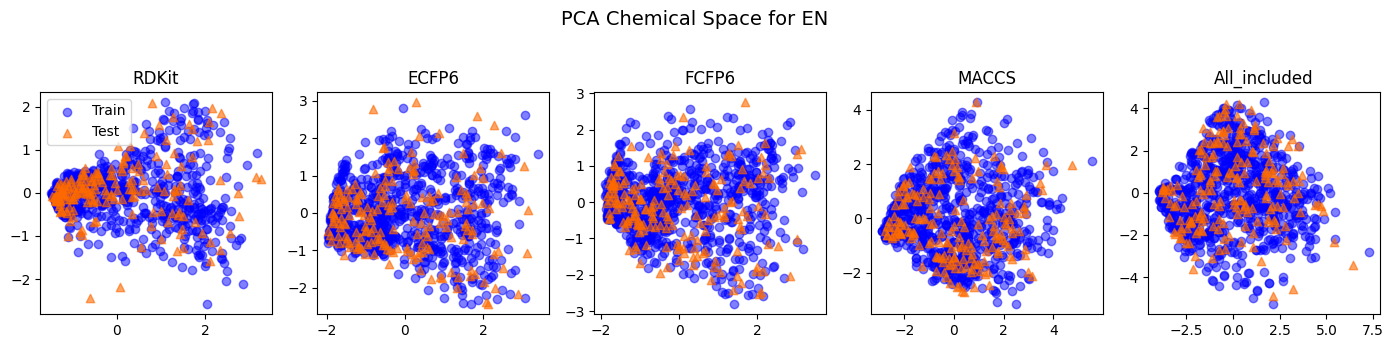

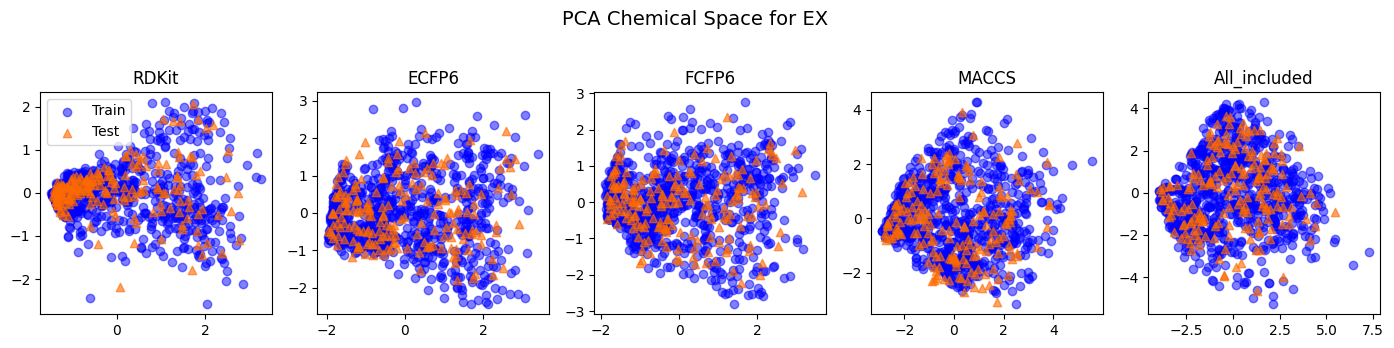

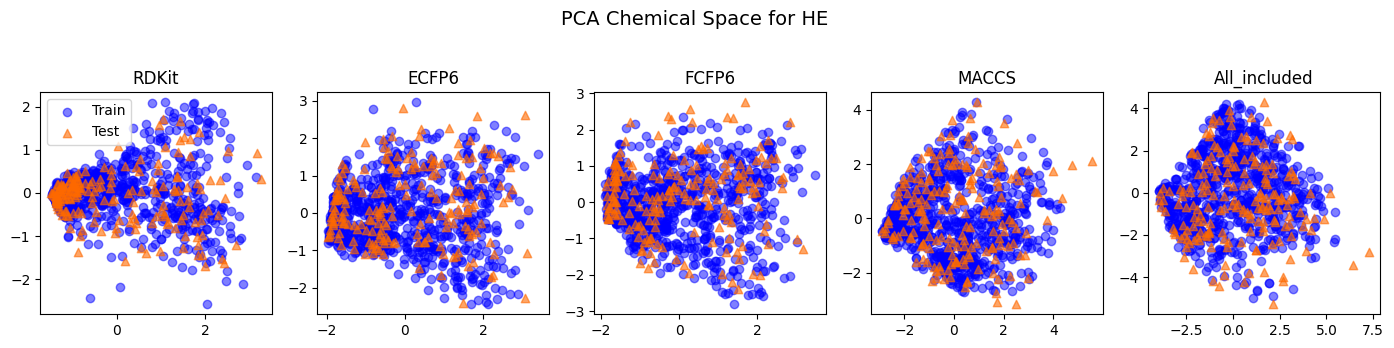

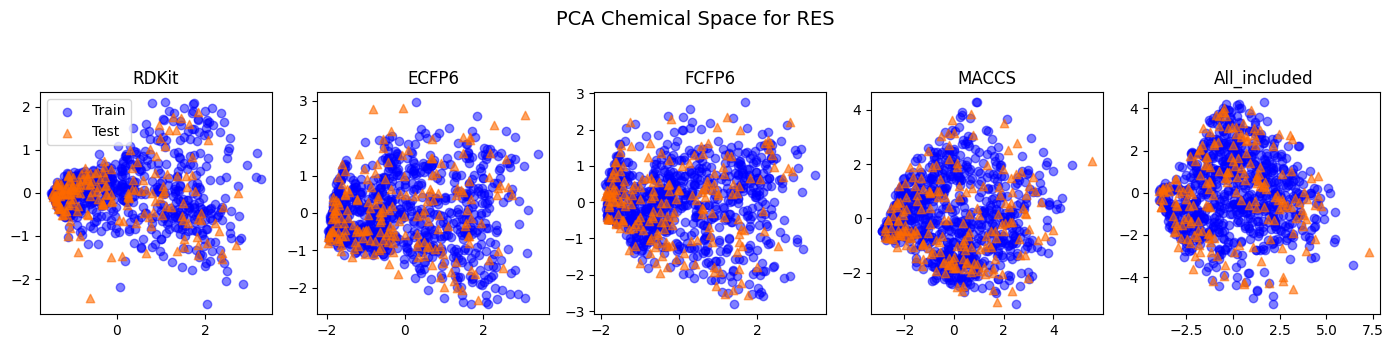

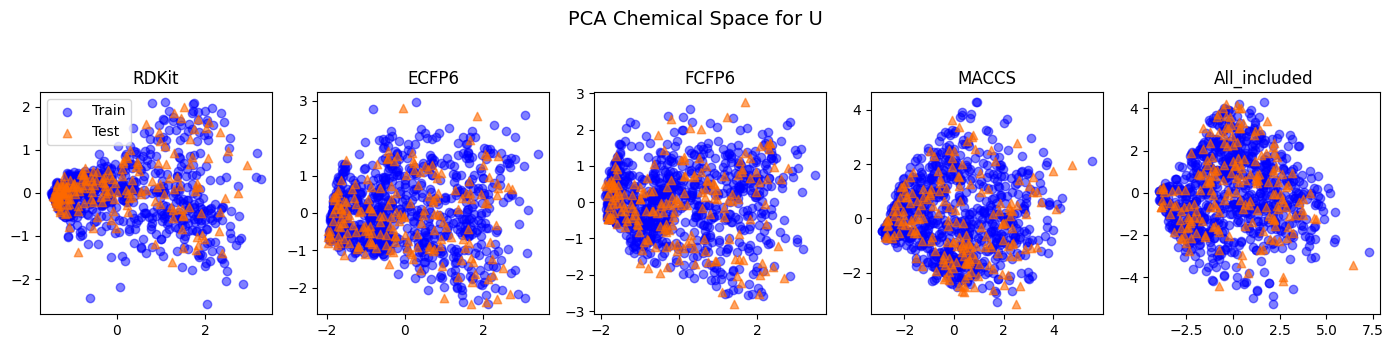

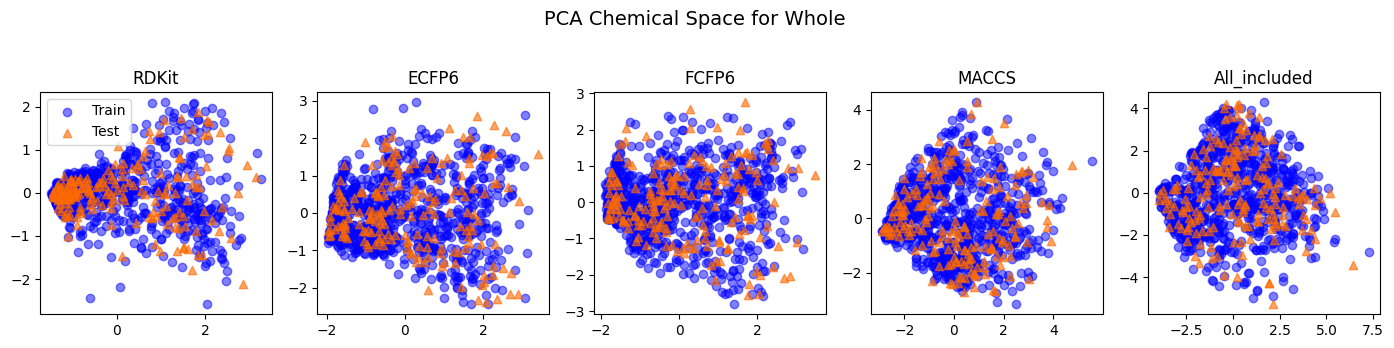

In [ ]:
# PCA plots for train-test set
for label_idx, label_name in enumerate(label_types[:6]):
    current_label = labels[label_idx]

    # Get indices and split into train and test sets using the current label for stratification.
    indices = np.arange(len(current_label))
    train_idx, test_idx = train_test_split(
        indices, test_size=0.2, random_state=42, stratify=current_label
    )

    # Create a figure with 6 subplots (one for each feature type)
    fig, axes = plt.subplots(1, 5, figsize=(14, 3.5))
    fig.suptitle(f'PCA Chemical Space for {label_name}', fontsize=14)

    for feat_idx, feat_name in enumerate(feature_types):
        X_feat = features[feat_idx]

        # Perform PCA on the feature matrix (projecting to 2D)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_feat)

        ax = axes[feat_idx]
        # Plot training samples in blue and test samples in orange
        ax.scatter(X_pca[train_idx, 0], X_pca[train_idx, 1],
                   color='blue', label='Train', alpha=0.5)
        ax.scatter(X_pca[test_idx, 0], X_pca[test_idx, 1],
                   color='#fe6900', label='Test', alpha=0.6, marker='^')
        ax.set_title(feat_name)
        if feat_idx == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figure with dpi=600
    plt.savefig(os.path.join(output_dir, f'PCA_{label_name}.png'), dpi=600)
    plt.show()

# Applicability Domain

In [ ]:
from numpy.linalg import pinv
from sklearn.metrics import pairwise_distances

# --- AD helper functions ---
def leverage_ad(X_train, X_test):
    """
    Returns (lever_test, threshold, in_domain_bool_array)
    using H* = 3*(p+1)/n_train, where p = n_features.
    """
    n_train, p = X_train.shape
    H_inv      = pinv(X_train.T @ X_train)
    lever_test = np.einsum('ij,jk,ik->i', X_test, H_inv, X_test)
    thresh     = 3 * (p + 1) / n_train
    in_domain  = lever_test <= thresh
    return lever_test, thresh, in_domain

def fingerprint_ad(X_train_fp, X_test_fp, sim_thresh=0.35):
    """
    Compute fingerprint‐based AD using Jaccard (Tanimoto) similarity.
    Returns (max_similarities, threshold, in_domain_bool_array).
    """
    # pairwise_distances(..., metric='jaccard') gives 1 - Tanimoto
    # 1) cast to bool
    X_train_bool = X_train_fp.astype(bool)
    X_test_bool  = X_test_fp.astype(bool)

    # 2) compute Jaccard distance, then convert to similarity
    jaccard_dist = pairwise_distances(X_test_bool, X_train_bool, metric="jaccard")
    sims         = 1 - jaccard_dist
    max_sim      = sims.max(axis=1)
    in_domain    = max_sim >= sim_thresh
    return max_sim, sim_thresh, in_domain

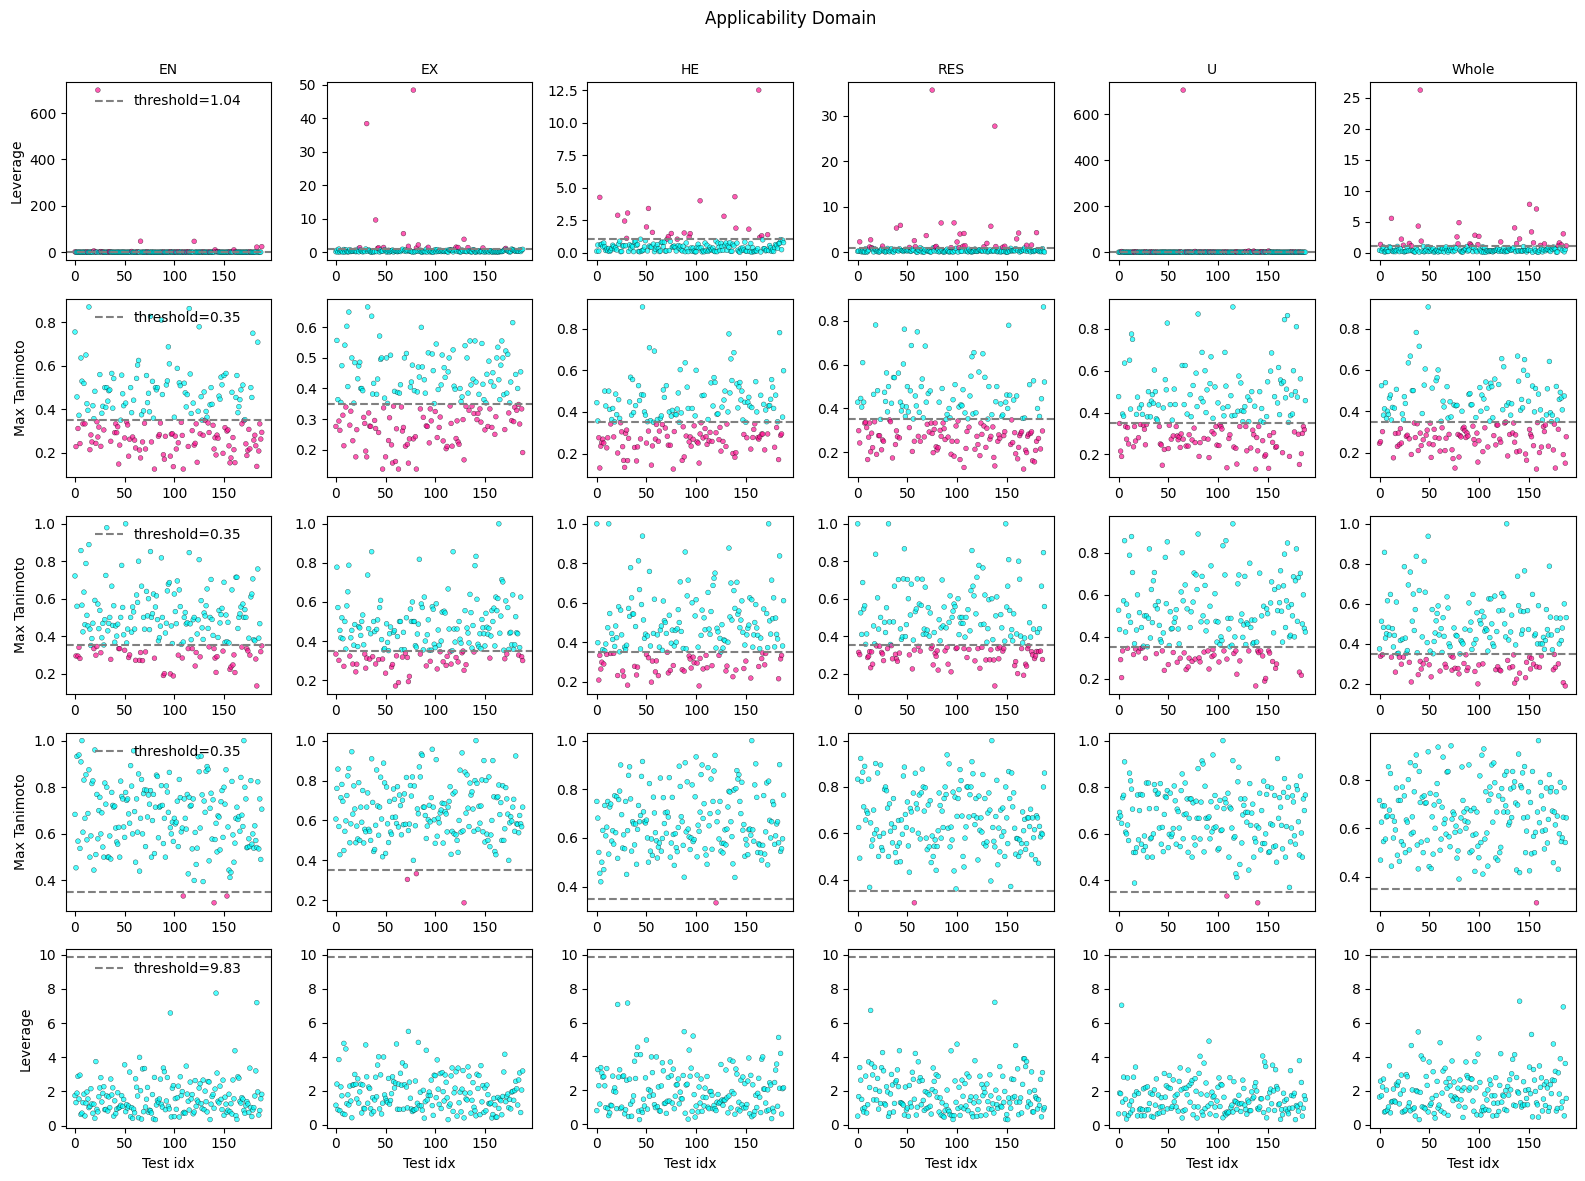

    Label   Feature_Set                      AD_Method  n_in_domain  \
0      EN         RDKit                       Leverage          157   
1      EX         RDKit                       Leverage          171   
2      HE         RDKit                       Leverage          165   
3     RES         RDKit                       Leverage          154   
4       U         RDKit                       Leverage          156   
5   Whole         RDKit                       Leverage          157   
6      EN         ECFP6  Fingerprint (Tanimoto ≥ 0.35)           95   
7      EX         ECFP6  Fingerprint (Tanimoto ≥ 0.35)          100   
8      HE         ECFP6  Fingerprint (Tanimoto ≥ 0.35)          101   
9     RES         ECFP6  Fingerprint (Tanimoto ≥ 0.35)           88   
10      U         ECFP6  Fingerprint (Tanimoto ≥ 0.35)          104   
11  Whole         ECFP6  Fingerprint (Tanimoto ≥ 0.35)           95   
12     EN         FCFP6  Fingerprint (Tanimoto ≥ 0.35)          139   
13    

In [ ]:
# Convert any DataFrames to NumPy arrays
features_np = [
    feat.values if hasattr(feat, "values") else np.asarray(feat)
    for feat in features]

labels_np = [
    lab.values if hasattr(lab, "values") else np.asarray(lab)
    for lab in labels]

fig, axes = plt.subplots(5, 6, figsize=(16, 12),
    sharex=False, sharey=False)

# --- Loop over feature × label combos and compute AD ---

results = []

for feat_idx, feat_name in enumerate(feature_types):
    X_full = features_np[feat_idx]

    for lab_idx, lab_name in enumerate(label_types):
        y = labels_np[lab_idx]
        idx = np.arange(len(y))

        # stratified train/test split
        tr_idx, te_idx = train_test_split(
            idx, test_size=0.2, random_state=42, stratify=y)
        X_train, X_test = X_full[tr_idx], X_full[te_idx]

        # Descriptor‐based AD (for RDKit and All_included)
        lever_test, lever_thresh, lever_in = leverage_ad(X_train, X_test)

        ax = axes[feat_idx, lab_idx]

        if feat_name in ["RDKit", "All_included"]:
            # Only descriptor AD
            in_domain = lever_in
            method    = "Leverage"
            thresh    = lever_thresh
            n_in      = np.sum(in_domain)
            ylabel     = "Leverage"
            colors     = ["#00FFFF" if v <= thresh else "#FF1493" for v in lever_test]

        else:    # "ECFP6", "FCFP6", "MACCS"
            # Only fingerprint AD on this single fingerprint set
            lever_test, sim_thresh, sim_in = fingerprint_ad(
                X_train, X_test, sim_thresh=0.35)
            in_domain = sim_in
            method    = "Fingerprint (Tanimoto ≥ 0.35)"
            thresh    = sim_thresh
            n_in      = np.sum(in_domain)
            ylabel     = "Max Tanimoto"
            colors     = ["#00FFFF" if v >= thresh else "#FF1493" for v in lever_test]

        # Record results
        results.append({
            "Label":        lab_name,
            "Feature_Set":  feat_name,
            "AD_Method":    method,
            "n_in_domain":  int(n_in),
            "pct_in_domain": f"{100*n_in/len(te_idx):.1f}%",
            "Threshold":    thresh,
            "n_test":       len(te_idx)
        })

        # plot
        ax.scatter(np.arange(len(lever_test)), lever_test,
            c=colors, s=12, edgecolor='k', linewidths=0.3, alpha=0.7)
        ax.axhline(thresh, linestyle="--", color="gray", label=f'threshold={thresh:.2f}')
        ax.set_xticks(np.arange(0, len(te_idx), 50))

        if feat_idx == 0:
            ax.set_title(lab_name, fontsize=10)
        if lab_idx == 0:
            ax.legend(loc='upper center', frameon=False)
            ax.set_ylabel(ylabel, fontsize=10)
        if feat_idx == 4:
            ax.set_xlabel("Test idx", fontsize=10)

# overall layout
fig.suptitle("Applicability Domain", fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f'Applicability Domain.png', dpi=500)
plt.show()

# Summarize in a DataFrame
ad_summary = pd.DataFrame(results)
print(ad_summary)

In [ ]:
All = pd.concat([X_rdkit_descrs_scal.reset_index(drop=True), ECFP6_descrs.reset_index(drop=True), FCFP6_descrs.reset_index(drop=True), MACCS_descrs.reset_index(drop=True)], axis = 1)

# Re-define feature types for QSAR
feature_types = ["RDKit", "ECFP6", "FCFP6", "MACCS", "All_included"]
features = [X_rdkit_descrs_scal, ECFP6_descrs, FCFP6_descrs, MACCS_descrs, All]

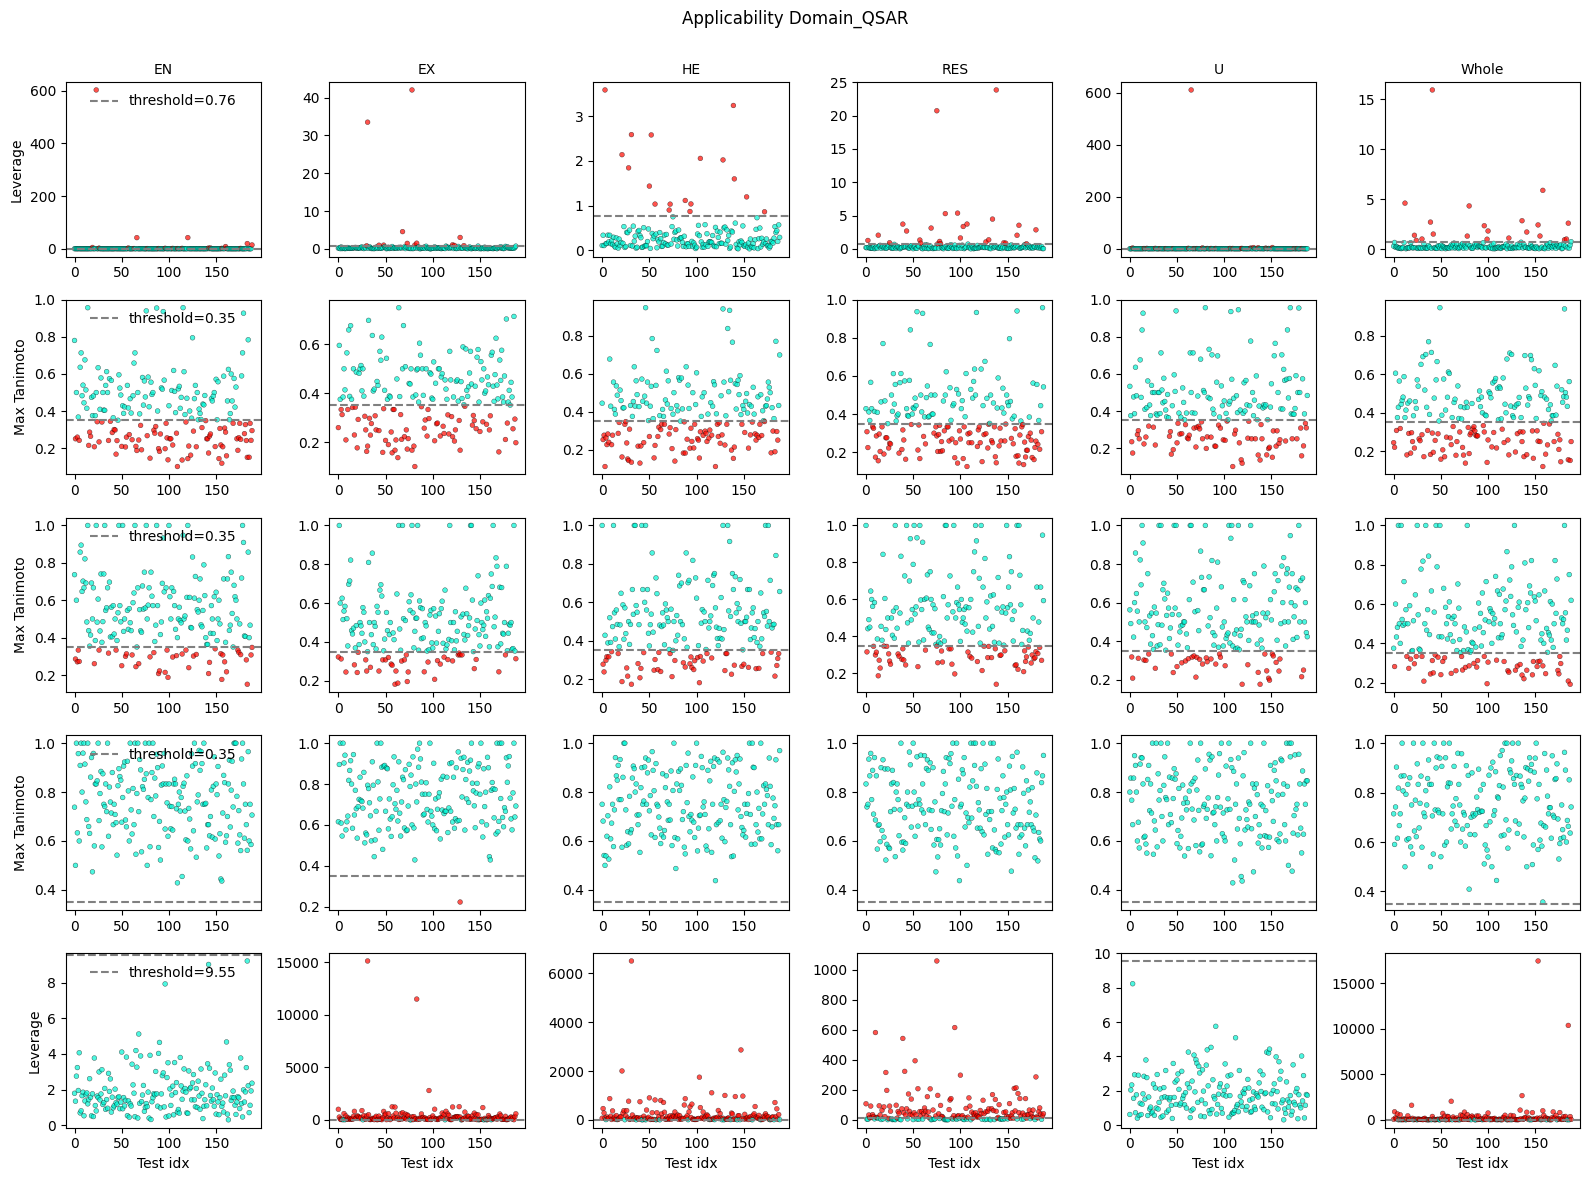

    Label   Feature_Set                      AD_Method  n_in_domain  \
0      EN         RDKit                       Leverage          168   
1      EX         RDKit                       Leverage          176   
2      HE         RDKit                       Leverage          171   
3     RES         RDKit                       Leverage          162   
4       U         RDKit                       Leverage          161   
5   Whole         RDKit                       Leverage          168   
6      EN         ECFP6  Fingerprint (Tanimoto ≥ 0.35)          108   
7      EX         ECFP6  Fingerprint (Tanimoto ≥ 0.35)          113   
8      HE         ECFP6  Fingerprint (Tanimoto ≥ 0.35)          105   
9     RES         ECFP6  Fingerprint (Tanimoto ≥ 0.35)           93   
10      U         ECFP6  Fingerprint (Tanimoto ≥ 0.35)          119   
11  Whole         ECFP6  Fingerprint (Tanimoto ≥ 0.35)          110   
12     EN         FCFP6  Fingerprint (Tanimoto ≥ 0.35)          146   
13    

In [ ]:
# Convert any DataFrames to NumPy arrays
features_np = [
    feat.values if hasattr(feat, "values") else np.asarray(feat)
    for feat in features]

labels_np = [
    lab.values if hasattr(lab, "values") else np.asarray(lab)
    for lab in labels]

fig, axes = plt.subplots(5, 6, figsize=(16, 12),
    sharex=False, sharey=False)

# --- Loop over feature × label combos and compute AD ---

results = []

for feat_idx, feat_name in enumerate(feature_types):
    X_full = features_np[feat_idx]

    for lab_idx, lab_name in enumerate(label_types):
        y = labels_np[lab_idx]
        idx = np.arange(len(y))

        # stratified train/test split
        tr_idx, te_idx = train_test_split(
            idx, test_size=0.2, random_state=42, stratify=y)
        X_train, X_test = X_full[tr_idx], X_full[te_idx]

        # Descriptor‐based AD (for RDKit and All_included)
        lever_test, lever_thresh, lever_in = leverage_ad(X_train, X_test)

        ax = axes[feat_idx, lab_idx]

        if feat_name in ["RDKit", "All_included"]:
            # Only descriptor AD
            in_domain = lever_in
            method    = "Leverage"
            thresh    = lever_thresh
            n_in      = np.sum(in_domain)
            ylabel     = "Leverage"
            colors     = ["#00f5d4" if v <= thresh else "#FF0800" for v in lever_test]

        else:    # "ECFP6", "FCFP6", "MACCS"
            # Only fingerprint AD on this single fingerprint set
            lever_test, sim_thresh, sim_in = fingerprint_ad(
                X_train, X_test, sim_thresh=0.35)
            in_domain = sim_in
            method    = "Fingerprint (Tanimoto ≥ 0.35)"
            thresh    = sim_thresh
            n_in      = np.sum(in_domain)
            ylabel     = "Max Tanimoto"
            colors     = ["#00f5d4" if v >= thresh else "#FF0800" for v in lever_test]

        # Record results
        results.append({
            "Label":        lab_name,
            "Feature_Set":  feat_name,
            "AD_Method":    method,
            "n_in_domain":  int(n_in),
            "pct_in_domain": f"{100*n_in/len(te_idx):.1f}%",
            "Threshold":    thresh,
            "n_test":       len(te_idx)
        })

        # plot
        ax.scatter(np.arange(len(lever_test)), lever_test,
            c=colors, s=12, edgecolor='k', linewidths=0.3, alpha=0.7)
        ax.axhline(thresh, linestyle="--", color="gray", label=f'threshold={thresh:.2f}')
        ax.set_xticks(np.arange(0, len(te_idx), 50))

        if feat_idx == 0:
            ax.set_title(lab_name, fontsize=10)
        if lab_idx == 0:
            ax.legend(loc='upper center', frameon=False)
            ax.set_ylabel(ylabel, fontsize=10)
        if feat_idx == 4:
            ax.set_xlabel("Test idx", fontsize=10)

fig.suptitle("Applicability Domain_QSAR", fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f'AD QSAR.png', dpi=500)
plt.show()

ad_summary = pd.DataFrame(results)
print(ad_summary)